In [26]:
import pandas as pd
import xgboost

In [29]:
import numpy as np # linear algebra
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [54]:

pal = sns.color_palette()

In [20]:
findspark.init()

In [21]:
import sys
print(sys.version)

3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]


In [27]:
df_train = pd.read_csv('C:/Users/uttas/Desktop/Resume/Python Projects/train.csv')

In [28]:
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [30]:
print('Total number of question pairs for training: {}'.format(len(df_train)))

Total number of question pairs for training: 404290


In [33]:
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100,2)))

Duplicate pairs: 36.92%


In [34]:
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())

In [35]:
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))

Total number of questions in the training data: 537933


In [37]:
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

Number of questions that appear multiple times: 111780


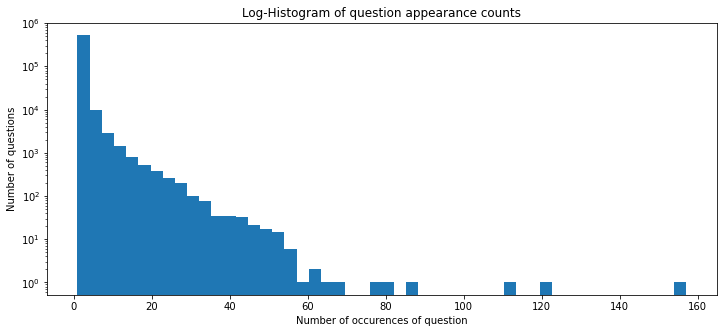

In [38]:
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In [154]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # Our predicted probability
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

Predicted score: 0.6585273839844354


In [155]:
df_test = pd.read_csv('C:/Users/uttas/Desktop/Resume/Python Projects/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('C:/Users/uttas/Desktop/Resume/Python Projects/naive_submission.csv', index=False)
sub.head()

C:\Users\uttas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,test_id,is_duplicate
0,0,0.369198
1,1,0.369198
2,2,0.369198
3,3,0.369198
4,4,0.369198


In [156]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [126]:
df_test=df_test.rename(columns={"question1": "1", "question2": "2"})

In [121]:
print('Total number of question pairs for testing: {}'.format(len(df_test)))

Total number of question pairs for testing: 3563475


In [122]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)

In [123]:
train_qs

0         What is the step by step guide to invest in sh...
1         What is the story of Kohinoor (Koh-i-Noor) Dia...
2         How can I increase the speed of my internet co...
3         Why am I mentally very lonely? How can I solve...
4         Which one dissolve in water quikly sugar, salt...
                                ...                        
808575    How many keywords are there in PERL Programmin...
808576           Is it true that there is life after death?
808577                                    What's this coin?
808578    I am having little hairfall problem but I want...
808579        What is it like to have sex with your cousin?
Length: 808580, dtype: object

In [127]:
test_qs = pd.Series(df_test['1'].tolist() + df_test['2'].tolist()).astype(str)

In [128]:
print(test_qs)

0          How does the Surface Pro himself 4 compare wit...
1          Should I have a hair transplant at age 24? How...
2          What but is the best way to send money from Ch...
3                                Which food not emulsifiers?
4                           How "aberystwyth" start reading?
                                 ...                        
7126945          What is the most study scene in twin peaks?
7126946               How question FedEx packages delivered?
7126947    Can a non-alcoholic restaurant be a huge success?
7126948    What are the best and worst things examination...
7126949        How do I out get rid of Erectile Dysfunction?
Length: 7126950, dtype: object


In [49]:
dist_train = train_qs.apply(len)

In [50]:
dist_train

0          66
1          51
2          73
3          50
4          76
         ... 
808575     79
808576     42
808577     17
808578    127
808579     45
Length: 808580, dtype: int64

In [51]:
dist_test = test_qs.apply(len)

Text(0, 0.5, 'Probability')

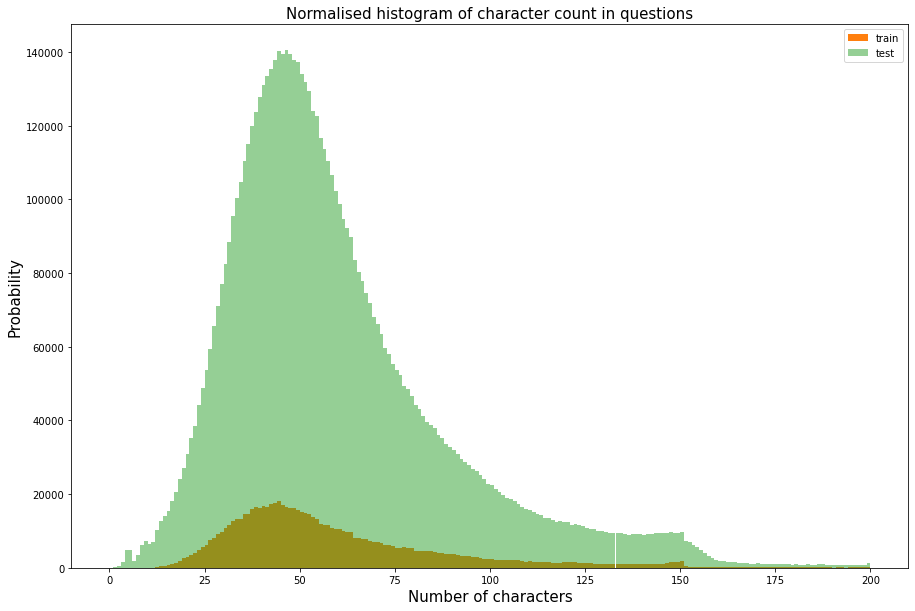

In [62]:
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200],color=pal[1], label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[2],alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [56]:
print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(),dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

mean-train 59.82 std-train 31.96 mean-test 60.07 std-test 31.63 max-train 1169.00 max-test 1176.00


In [63]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))

In [64]:
dist_train

0         14
1          8
2         14
3         11
4         13
          ..
808575    13
808576     9
808577     3
808578    25
808579    10
Length: 808580, dtype: int64

In [65]:
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

In [66]:
dist_test

0          11
1          14
2          14
3           4
4           4
           ..
7126945     9
7126946     5
7126947     8
7126948    20
7126949     9
Length: 7126950, dtype: int64

Text(0, 0.5, 'Probability')

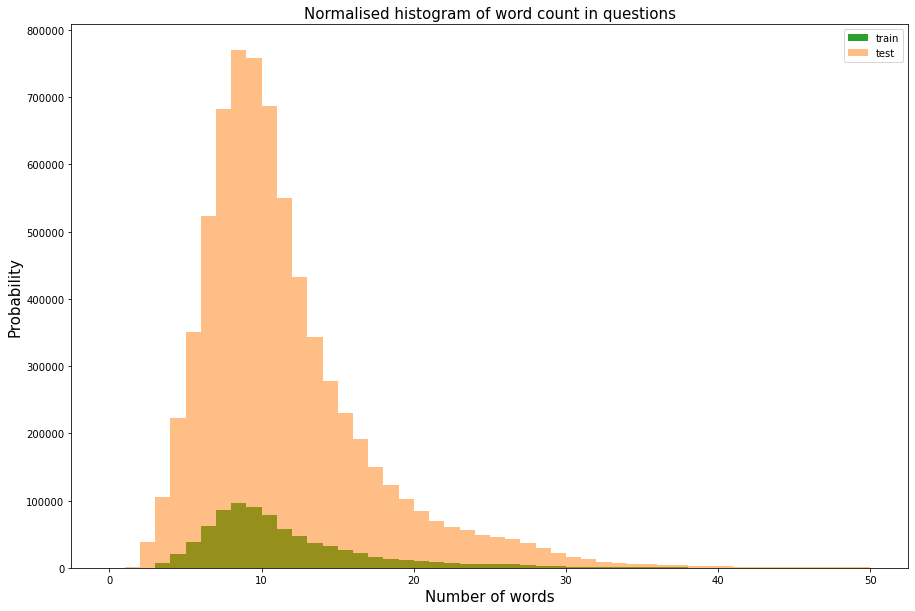

In [68]:
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [69]:
print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


(-0.5, 1439.5, 1079.5, -0.5)

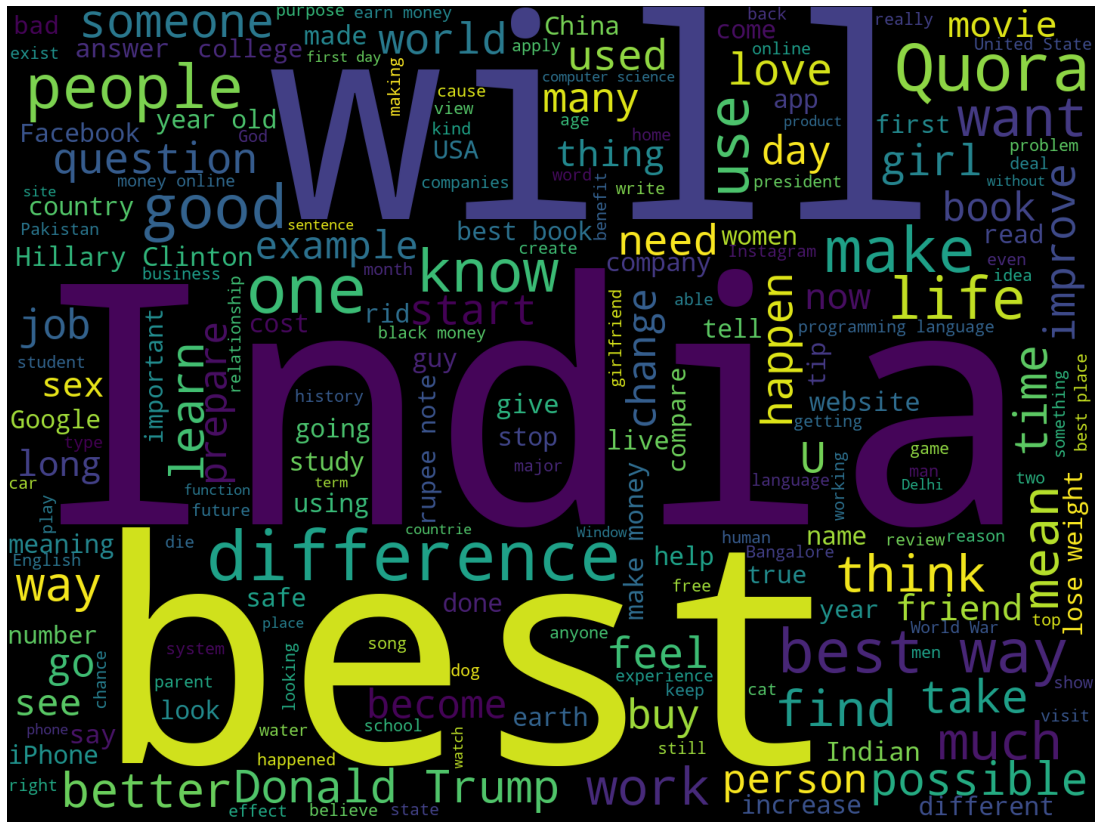

In [71]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [72]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))

In [73]:
qmarks

0.9987385292735412

In [74]:
math = np.mean(train_qs.apply(lambda x: '[math]' in x))

In [75]:
math

0.0011736624700091518

In [76]:
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))

In [77]:
fullstop

0.06308219347498083

In [78]:
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))

In [79]:
capital_first

0.9981325286304386

In [80]:
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))

In [81]:
capitals

0.9995053055974672

In [82]:
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

In [83]:
numbers

0.11827153775755027

In [84]:
print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


In [129]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row[1]).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row[2]).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uttas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text(0.5, 0, 'word_match_share')

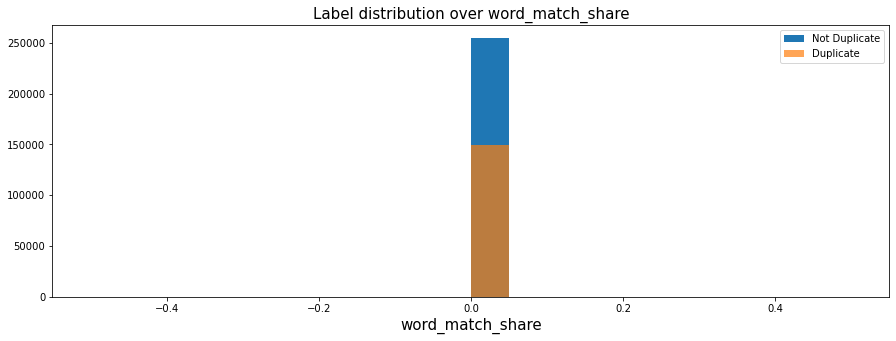

In [112]:
plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [91]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [92]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 


[('シ', 9.998000399920016e-05),
 ('し?', 9.998000399920016e-05),
 ('19-year-old.', 9.998000399920016e-05),
 ('1-855-425-3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('fab', 9.998000399920016e-05),
 ('109?', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05),
 ('fulfill?', 9.998000399920016e-05)]

In [134]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row[1]).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row[2]).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

<ipython-input-93-d44aceb8972a>:17: RuntimeWarning: invalid value encountered in double_scalars
  R = np.sum(shared_weights) / np.sum(total_weights)


Text(0.5, 0, 'word_match_share')

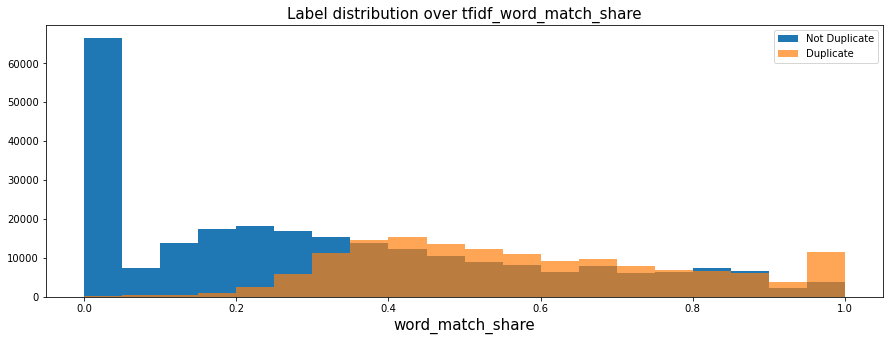

In [96]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [97]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.7804327049353577
   TFIDF AUC: 0.7704802292218704


In [135]:
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)

y_train = df_train['is_duplicate'].values

<ipython-input-134-4670027015c0>:17: RuntimeWarning: invalid value encountered in double_scalars
  R = np.sum(shared_weights) / np.sum(total_weights)
<ipython-input-134-4670027015c0>:17: RuntimeWarning: invalid value encountered in long_scalars
  R = np.sum(shared_weights) / np.sum(total_weights)


In [136]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [144]:
import sklearn
from sklearn.model_selection import train_test_split


x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [145]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.68365	valid-logloss:0.68364
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.60556	valid-logloss:0.60611
[20]	train-logloss:0.55084	valid-logloss:0.55182
[30]	train-logloss:0.51122	valid-logloss:0.51242
[40]	train-logloss:0.48182	valid-logloss:0.48329
[50]	train-logloss:0.45964	valid-logloss:0.46140
[60]	train-logloss:0.44303	valid-logloss:0.44481
[70]	train-logloss:0.43019	valid-logloss:0.43213
[80]	train-logloss:0.42028	valid-logloss:0.42237
[90]	train-logloss:0.41261	valid-logloss:0.41481
[100]	train-logloss:0.40662	valid-logloss:0.40899
[110]	train-logloss:0.40206	valid-logloss:0.40441
[120]	train-logloss:0.39841	valid-logloss:0.40084
[130]	train-logloss:0.39554	valid-logloss:0.39803
[140]	train-logloss:0.39334	valid-logloss:0.39585
[150]	train-logloss:0.39165	valid-logloss:0.39411
[160]	train-logloss:0.39024	valid-logloss:0.39275
[170]	trai

In [146]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

In [159]:
df_test

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?
...,...,...,...
3563470,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?
3563471,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?
3563472,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?
3563473,2345794,What were the best and worst things about publ...,What are the best and worst things examination...


In [163]:
sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['question1'] = df_test['question1']
sub['question2'] = df_test['question2']
sub['is_duplicate'] = p_test

In [164]:
sub

,test_id,question1,question2,is_duplicate
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,0.126575
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,0.348617
2,2,What but is the best way to send money from Ch...,What you send money to China?,0.348617
3,3,Which food not emulsifiers?,What foods fibre?,0.000824
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,0.545781
...,...,...,...,...
3563470,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?,0.000824
3563471,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?,0.066390
3563472,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?,0.000824
3563473,2345794,What were the best and worst things about publ...,What are the best and worst things examination...,0.438960


In [166]:
sub.to_csv('C:/Users/uttas/Desktop/Resume/Python Projects/simple_xgb.csv', index=False)